In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole # may be needed for viewing of molecules in notebook

### This problem involves predicting hERG-related cardiotoxicity. A common problem in drug development is that many drugs bind to the ion channel encoded for by the human ether-a-go-go related gene (hERG). Since this ion channel is involved in cardiac repolarization, binding to it and inhibiting it is not desirable.


In [69]:

#data_url = 'https://www.pnas.org/highwire/filestream/848445/field_highwire_adjunct_files/1/pnas.1810847116.sd01.xlsx'
#mols_df = pd.read_excel(data_url, sheet_name='HERG')

"""
!!! PNAS recently designed their website. Please load file from the project directory instead. !!!
"""
mols_df = pd.read_excel('pnas.1810847116.sd01.xlsx', sheet_name='HERG')
mols_df.head()

c:\Users\kylek\anaconda3\envs\my-rdkit-env\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,CANONICAL_SMILES,MOD,DOF_IC50_uM,Class,Source
0,c1cc(ccc1C(=O)Nc2ccn(n2)CCC#N)Cl,=,248.899834,Inactive,Pfizer
1,c1c2c([nH]n1)ncnc2N3CCCCC3,>,200.000000,Inactive,Pfizer
2,Cc1nc(on1)c2ccc(cc2)C(=O)OC,>,200.000000,Inactive,Pfizer
3,c1cc(cc(c1)F)NS(=O)(=O)c2cc(ccc2F)C(=O)O,>,200.000000,Inactive,Pfizer
4,Cc1nc(on1)c2ccc(cc2)C(=O)N,>,200.000000,Inactive,Pfizer


<p>At it's heart, this problem is simple classification with two classes: <code>Class = Inactive</code> and <code>Class = Active</code></p>
<p>But what are our features? Well let's use the fingerprints we discussed above. You'll need to generate a fingerprint for each row and then stack into a feature matrix.</p>

In [142]:
mols_df['fingerprint'] = mols_df.loc[:,'CANONICAL_SMILES'].apply(lambda x : np.array(AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), 3, nBits=1024)))
feature_matrix = mols_df.copy(deep=True).fingerprint.apply(pd.Series)


<p>The tasks are as follows:</p>
<ol>
<li><p>Do PCA on the fingerprint feature matrix and plot data using first two components of PCA, color code by class.</p>
</li>
<li><p>Create a classification model. You can use anything you like, though I would probably sugggest Random Forests or XGBoost. SVMs will work too. And you can try Neural Nets or Graph Neural Nets if you want, but perhaps overkill on this dataset. Please only submit one model. Please be principled in your hyperparameter searching and performance testing. I would like to see performance measured by both AUC-ROC and Precision-Recall curves.</p>
</li>
<li><p>In the spirit of principled performance testing and understanding variability, please implement nested cross validation. Report and comment on results and see if they add more info from results in 2.</p>
</li>


### -----------------------------------1. PCA, color code by class -------------------------------------------

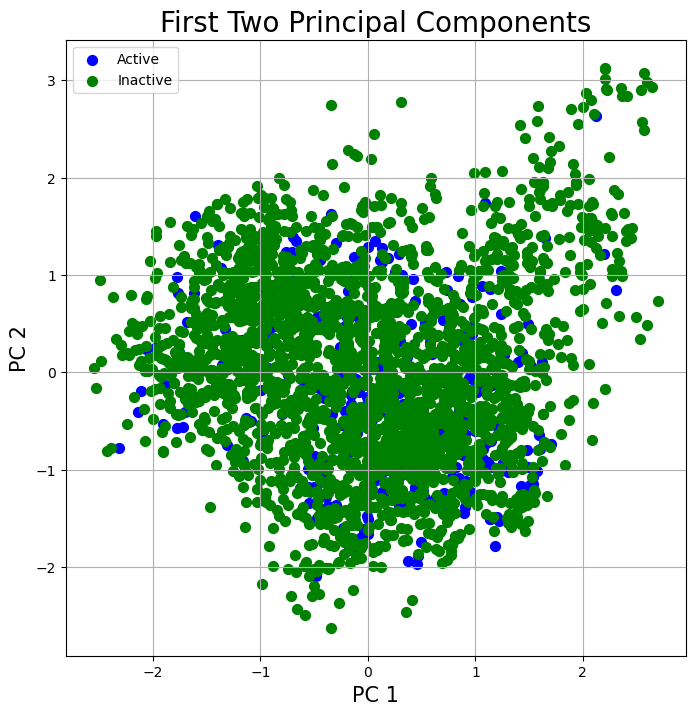

In [165]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pcs = pca.fit_transform(feature_matrix)
principalDf = pd.DataFrame(data = pcs
             , columns = ['principal component 1', 'principal component 2','principal component 3'])
principalDf = pd.concat([principalDf, mols_df[['Class']]], axis = 1)


fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
ax.set_title('First Two Principal Components', fontsize = 20)
targets = ['Active', 'Inactive']
colors = ['b', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['Class'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()





### ---------------------------------------------- 2-3 Build a Classifier ---------------------------------------------------- 

In [162]:
mols_df['Class'].value_counts()

Inactive    2352
Active       348
Name: Class, dtype: int64

#### Evaluating Sampling Strategies & Baseline Model:
##### Because the target class has some pretty big class imbalance, my first step is going to be running a few different quick-and-dirty models while trying different sampling strategies. Oversampling and undersampling is performed on the training dataset within each CV fold separately, ensuring that there is no data leakage as might occur if the oversampling was performed prior to the cross-validation. I also tried the balanced random forest mode from imblearn. (Note: This is meant to be quick and dirty evaluation of models and sampling strategies so only defaults hyperparameters are used here)


In [200]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier

y = mols_df['Class'].copy(deep = True).apply(lambda x : 1 if x == 'Active' else 0)
# First perform a train-test split. We will use the training set to select sampling strategy/model via cross validation (and later nested cross validation)
X_train, X_test, y_train, y_test = train_test_split(feature_matrix,y, test_size = 0.2, 
random_state=42,stratify = y)


scoring = {'f1_macro': 'f1_macro',
           'recall': 'recall',
           'precision': 'precision'}



steps = [('model', RandomForestClassifier(random_state=42))]
pipeline_rf = Pipeline(steps=steps)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# f1_macro returns a more objective measure of model performance
scores_rf =  cross_validate(pipeline_rf,X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1,return_train_score=True)


steps = [('over', RandomOverSampler()), ('model', RandomForestClassifier(random_state=42))]
pipeline_ros_rf = Pipeline(steps=steps)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# f1_macro returns a more objective measure of model performance
scores_ros_rf =  cross_validate(pipeline_ros_rf, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1,return_train_score=True)


steps = [('model', BalancedRandomForestClassifier(random_state = 42))]
pipeline_balanced_rf = Pipeline(steps=steps)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# f1_macro returns a more objective measure of model performance
scores_balanced_rf =  cross_validate(pipeline_balanced_rf, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1,return_train_score=True)

steps = [('under', RandomUnderSampler()), ('model', RandomForestClassifier(random_state=42))]
pipeline_rus_rf = Pipeline(steps=steps)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# f1_macro returns a more objective measure of model performance
scores_rus_rf =  cross_validate(pipeline_rus_rf, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1,return_train_score=True)


################# XGBOOST ############################################
steps = [('model', XGBClassifier(random_state=42))]
pipeline_xgb = Pipeline(steps=steps)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# f1_macro returns a more objective measure of model performance
scores_xgb =  cross_validate(pipeline_xgb,X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1,return_train_score=True)


steps = [('over', RandomOverSampler()), ('model', XGBClassifier(random_state=42))]
pipeline_ros_xgb = Pipeline(steps=steps)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# f1_macro returns a more objective measure of model performance
scores_ros_xgb =  cross_validate(pipeline_ros_xgb,X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1,return_train_score=True)


steps = [('under', RandomUnderSampler()), ('model', XGBClassifier(random_state=42))]
pipeline_rus_xgb = Pipeline(steps=steps)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# f1_macro returns a more objective measure of model performance
scores_rus_xgb =  cross_validate(pipeline_rus_xgb, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1,return_train_score=True)

quick_and_dirty_df = pd.DataFrame({'Model':['RF', 'ROS_RF', 'RUS_RF', 'BALANCED_RF','XGB','ROS_XGB','RUS_XGB'],
        'CV_Mean_Test_F1_Macro': [np.mean(scores_rf['test_f1_macro']), np.mean(scores_ros_rf['test_f1_macro']), np.mean(scores_rus_rf['test_f1_macro']), 
        np.mean(scores_balanced_rf['test_f1_macro']),np.mean(scores_xgb['test_f1_macro']),np.mean(scores_ros_xgb['test_f1_macro']),np.mean(scores_rus_rf['test_f1_macro'])],
        'CV_Mean_Test_Recall' : [np.mean(scores_rf['test_recall']), np.mean(scores_ros_rf['test_recall']), np.mean(scores_rus_rf['test_recall']), 
        np.mean(scores_balanced_rf['test_recall']),np.mean(scores_xgb['test_recall']),np.mean(scores_ros_xgb['test_recall']),np.mean(scores_rus_xgb['test_recall'])],
        'CV_Mean_Test_Precision' : [np.mean(scores_rf['test_precision']), np.mean(scores_ros_rf['test_precision']), np.mean(scores_rus_rf['test_precision']), 
        np.mean(scores_balanced_rf['test_precision']),np.mean(scores_xgb['test_precision']),np.mean(scores_ros_xgb['test_precision']),np.mean(scores_rus_xgb['test_precision'])]})

quick_and_dirty_df




,Model,CV_Mean_Test_F1_Macro,CV_Mean_Test_Recall,CV_Mean_Test_Precision
0,RF,0.643579,0.214784,0.904726
1,ROS_RF,0.707334,0.346732,0.748686
2,RUS_RF,0.675003,0.750693,0.355272
3,BALANCED_RF,0.698354,0.749394,0.388953
4,XGB,0.724864,0.383831,0.752446
5,ROS_XGB,0.733499,0.439026,0.660322
6,RUS_XGB,0.675003,0.711147,0.315786


### Tuning the best model selected from the previous step: (Nested Cross Validation)

#### We can see from above that an under sampling strategy is optimal if we want a relatively high recall. We care about recall because we want to find as many of the true 'Active' molecules possible because if we miss 'Active' molecules they will bind to hERG and cause problems. I've chosen the balanced random forest model from imbalanced-learn to further perform hyperparameter tuning. (A balanced random forest randomly under-samples each boostrap sample to balance it.) 

In [ ]:
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
cv =  RepeatedStratifiedKFold(n_splits=5, n_repeats=3)


n_estimators = [100, 200, 500,1000,2000] # I have 1024 features and around 3k samples. I don't want features with high predictive power to be left out.
max_features = [np.sqrt(1024),60,100] # increase the chance that good features will be included.
param_grid = dict( n_estimators = n_estimators, max_features = max_features)

tune_rf_clf = GridSearchCV(estimator=BalancedRandomForestClassifier(random_state = 42), param_grid=param_grid , cv=cv, scoring = 'recall', n_jobs = -1)
tune_rf_clf.fit(X_train,y_train)
# Continue as usual


In [235]:
import pickle
print('Best Mean Test Recall from CV')
print(tune_rf_clf.best_score_)
print('Best parameters:')
print(tune_rf_clf.best_params_)
print('Saving best model from gridsearchcv object:')
filename = 'finalized_model.pkl'
pickle.dump(tune_rf_clf.best_estimator_, open(filename, 'wb'))

Best Mean Test Recall from CV
0.7723809523809524
Best parameters:
{'max_features': 60, 'n_estimators': 2000}
Saving best model from gridsearchcv object:


#### Hyperparameter tuning improved the mean CV test recall from 0.74  to 0.77. My intuition that increasiing n_estimators and max_features will increase the chance of important feautres being included in the individal trees was on the right track. We now check performances of our tuned model on *completely unseen test set*. 

Classification report of the tuned balanced random forest model
              precision    recall  f1-score   support

           0       0.96      0.82      0.89       470
           1       0.39      0.76      0.51        70

    accuracy                           0.81       540
   macro avg       0.67      0.79      0.70       540
weighted avg       0.88      0.81      0.84       540



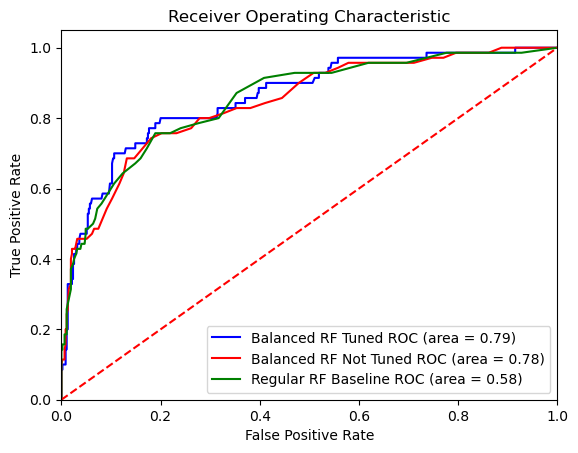

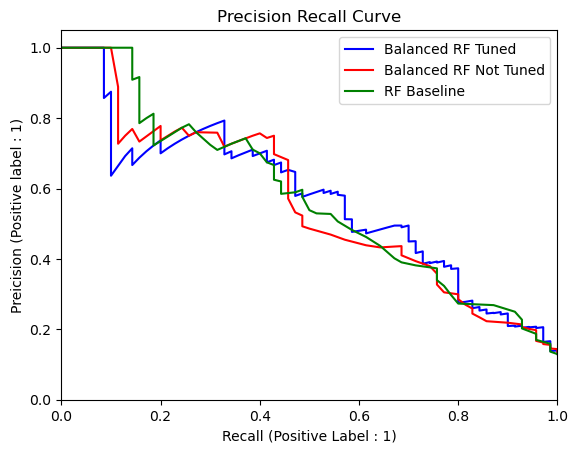

In [236]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score,confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix,precision_recall_curve, classification_report

predictions = tune_rf_clf.predict(X_test)
print('Classification report of the tuned balanced random forest model')
print(metrics.classification_report(y_test,predictions))
fpr, tpr, thresholds = metrics.roc_curve(y_test,tune_rf_clf.predict_proba(X_test)[:,1])
precision_1, recall_1, thresholds_1 = precision_recall_curve(y_test,tune_rf_clf.predict_proba(X_test)[:,1])
auc = roc_auc_score(y_test, predictions)
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ("Balanced RF Tuned", auc),color='b')


balanced_rf = BalancedRandomForestClassifier(random_state = 42)
balanced_rf.fit(X_train,y_train)
predictions = balanced_rf.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test,balanced_rf.predict_proba(X_test)[:,1])
precision_2, recall_2, thresholds_2 = precision_recall_curve(y_test,balanced_rf.predict_proba(X_test)[:,1])
auc = roc_auc_score(y_test, predictions)
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ("Balanced RF Not Tuned", auc),color='r')

rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train,y_train)
predictions = rf.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test,rf.predict_proba(X_test)[:,1])
auc = roc_auc_score(y_test, predictions)
precision_3, recall_3, thresholds_3 = precision_recall_curve(y_test,rf.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ("Regular RF Baseline", auc),color='g')

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
plt.clf()


### Plotting the Precision Recall Curve

plt.plot( recall_1,precision_1, label = "Balanced RF Tuned", color='b')
plt.plot( recall_2, precision_2, label= "Balanced RF Not Tuned",color='r')
plt.plot( recall_3,precision_3, label= "RF Baseline",color='g')


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall (Positive Label : 1)')
plt.ylabel('Preicision (Positive label : 1)')
plt.title('Precision Recall Curve')
plt.legend(loc="upper right")

##### Comparing AUC (area under the curve) we see the biggest boost in performance is due to our random forest model taking into account the target class imbalance by implementing random undersampling for each bootstrapped sample. This alone increased AUC from 0.58 to 0.78!! Hyperparameter tuning of the balanced random forest only improved the model slightly by making it able to achieve the same recall with relatively higher precision when recall is greater than 0.5